# Building a Twitter Sentiment Analyzer

## 0. Descripción

El propósito de este notebook es crear una herramienta que sirva como predictora del sentimiento de tweets en Español basándonos en un algoritmo de machine learning entrenado.

Para el entrenamiento, se ha empleado un dataset con más de 70.000 tweets labelizados en sentimiento negativo, neutro y positivo proporcionado por SEPLN (Spanish Society for Natural Language Processing). También se ha añadido otro set de datos clasificados del que han sido empleados aproximadamente 45.000 tweets.

Para el tratamiento de los datos se han elaborado script que reducen al mínimo el contenido de los tweets intentando preservar el máximo de información. Las transformaciones que se han realizado han sido:
- Eliminación de signos de puntuación
- Supresión de emojis por las etiquetas {emoji_neg}, {emoji_neu}, {emoji_pos}
- Normalización de expresiones que indicasen risa por 'jajaja', 'jejeje', 'jijiji', 'jojojo', 'jujuju'. No han sido revertidas todas a la misma expresión porque el significado de cada una puede ser completamente distinto.
- Eliminación de stopwords, haciendo cambios en las stopwords predefinidas y dejando intactas las negaciones y algunos pronombres personales que pueden indicar cercanía.
- Supresión de hashtags, links y menciones por {hash}, {link} y {menc}.
- Lematización de todas las palabras con la librería Spacy.

En la construcción de modelos se han optado por redes neuronales de capas GRU, RNN con capas LSTM, RNN bidireccionales y un modelo de red neuronal convolucional 1D. También se han valorado mediante la técnica de CountVectorizer e TFIFD la regresión logística, random forest y SVM como clasificadores. El algoritmo que mejor accuracy ha obtenido ha sido la regresión logística mediante Count Vectorizer, con más del 76% de acierto.

Finalmente, el modelo funciona bien sin tener que haber recurrido a la hiperparametrización, lo que indica que el rendimiento podría ser incluso mejor. Aun así, dada la baja calidad del dataset, el modelo llega a confundir con frecuencia entre negativo-neutro y positivo-neutro, no así entre tweets negativo-positivo. Estas limitaciones intentarán solventarse en próximas iteraciones del modelo.

## 1. Tratando el dataset

In [2]:
#!python -m spacy download es_core_news_md

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


In [4]:
# Importamos librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [5]:
# Cargamos los dos datasets con tweets categorizads
df_1 = pd.read_csv('data\\df_combined.csv', sep=';', index_col = 0)
df_2 = pd.read_csv('data\\df_tweets_by_id.csv', sep=';', index_col = 0)

print('df_1 shape:', df_1.shape)
print('df_2 shape:', df_2.shape)

df_1 shape: (20837, 6)
df_2 shape: (57181, 3)


In [6]:
# Cargamos más datos
df_pos = pd.read_csv('data\\tweets_pos.txt', sep='delimiter', encoding='utf-8', names=['content'])
df_neu = pd.read_csv('data\\tweets_neu.txt', sep='delimiter', encoding='utf-8', names=['content'])
df_neg = pd.read_csv('data\\tweets_neg.txt', sep='delimiter', encoding='utf-8', names=['content'])

# Añadimos columna sentiment
df_pos['sentiment'] = 'P'
df_neu['sentiment'] = 'NEU'
df_neg['sentiment'] = 'N'

# Añadimos ID ficticio
#df_pos['sentiment'] = 'P'



# Barajamos
#df_pos, df_neu, df_neg = shuffle([df_pos, df_neu, df_neg],
#                                 random_state = 42)

# Seleccionamos 15000 de cada uno
df_pos = df_pos.loc[:15000]
df_neu = df_neu.loc[:15000]
df_neg = df_neg.loc[:15000]

# Concatenamos en un único df
df_extra = pd.concat([df_pos, df_neu, df_neg]).reset_index(drop=True)

# Imprimimos tamaño
df_extra.shape

(45003, 2)

In [7]:
# Eliminamos los duplicados
df_extra.drop_duplicates(inplace = True)

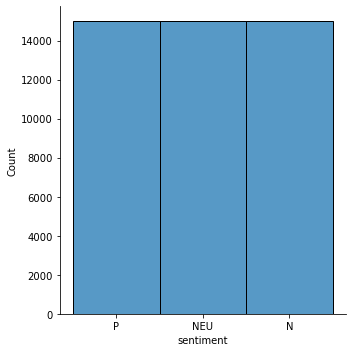

In [8]:
sns.displot(df_extra.sentiment)

In [9]:
# Normalizamos nombres de columnas
df_2.rename(columns={'text': 'content'}, inplace=True)

In [10]:
# Convergemos en un único dataset
df = pd.concat([df_1, df_2, df_extra]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123021 entries, 0 to 123020
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tweetid    78018 non-null   float64
 1   user       20837 non-null   object 
 2   content    123020 non-null  object 
 3   date       20837 non-null   object 
 4   sentiment  123021 non-null  object 
 5   topics     20837 non-null   object 
dtypes: float64(1), object(5)
memory usage: 5.6+ MB


In [11]:
# Comprobamos duplicados
df.content.duplicated().sum()

5170

In [12]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'content', inplace = True)

# Dejamos las columnas tweetid y content
df.drop(['user', 'date', 'topics', 'tweetid'], 1, inplace = True)

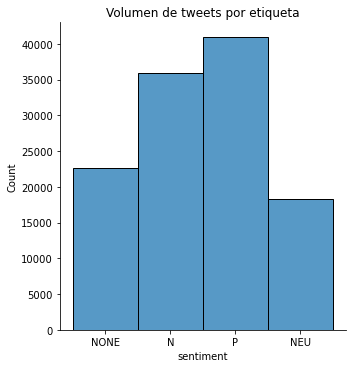

In [13]:
# Comprobamos distribución de la etiqueta 'sentiment'
sns.displot(df.sentiment)
plt.title('Volumen de tweets por etiqueta');


NEU    40982
P      40950
N      35919
Name: sentiment, dtype: int64
Tamaño del dataset: (117851, 2)


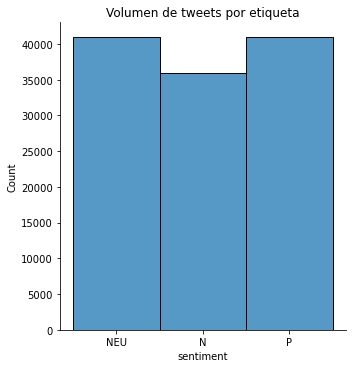

In [14]:
# Combinamos el sentimiento NEUTRO con NONE ya que en la práctica es similar
df.sentiment = df.sentiment.apply(lambda x: x.replace('NONE', 'NEU'))

# Volvemos a comprobar distribución de la etiqueta 'sentiment'
sns.displot(df.sentiment)
plt.title('Volumen de tweets por etiqueta');

print(df.sentiment.value_counts())
print('Tamaño del dataset:', df.shape)

In [15]:
# Comprobamos nulls
print(df.isnull().sum())

content      1
sentiment    0
dtype: int64


In [16]:
# ELiminamos nulls
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [17]:
# Comprobamos nulls
print(df.isnull().sum())

content      0
sentiment    0
dtype: int64


## 2. Tratando el contenido

Aplicamos las siguientes transformaciones:
- Tokenizamos tweets
- Sustituir enlaces por {link} y emojis por su significado/valor
- Eliminamos signos de puntuación
- Transformar a minúscula
- Corregir abreviacion de palabras
- Eliminar letras repetidas
- Eliminamos stop words
- Eliminamos todo lo que no sean palabras
- Eliminar acentos

In [18]:
# Sustituimos menciones, link y emojis
# Normalizamos risas
# Eliminamos letras repetidas
# Sustituimos signos de puntuacion
# Corregimos abreviaciones
# Eliminamos stopwords
# Lematizamos

In [19]:
# Eliminamos signos de puntuación
import re

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

df.content[:50].apply(remove_punctuation_space)


0     en el templo del spd, willy-brandt-haus en ber...
1     grabado hace 4 meses con algo d polemica, el m...
2     “@eatonvidal: @edurnity mi segundo apellido es...
3     “@anagamoral: @edurnity mi terecer apellido es...
4     “@anagamoral: @edurnity mi sexto apellido es c...
5          esta mañana navegaba. ahora voy en autobús .
6     rafa nos ha vuelto a hacer vibrar. sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     hoy prefiero no contaros la portada. es mejor ...
9     las dos argentinas del #corralito http://t o/k...
10    camino a @lavozmexico   no se pierdan las actu...
11    sra. rushmore estrena la peineta http://t o/sw...
12    jeje  iii!! rt @dalearden_ @tonicanto1 :))) te...
13                            @carlosecue un comunicado
14    tenemos enormes dudas sobre la proposición de ...
15    que gran verdad! “@sonya_back: @federicoqueved...
16    con mis hermanos wisin & yandel en el coliseo ...
17    a dos minutos de que @pacorengel me haga l

In [20]:
# Eliminamos signos de puntuación
import re

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

df.content[:50].apply(remove_punctuation)


0     en el templo del spd willybrandthaus en berlín...
1     grabado hace  meses con algo d polemica el mié...
2     @eatonvidal @edurnity mi segundo apellido es v...
3     @anagamoral @edurnity mi terecer apellido es v...
4     @anagamoral @edurnity mi sexto apellido es cab...
5             esta mañana navegaba ahora voy en autobús
6     rafa nos ha vuelto a hacer vibrar sin duda el ...
7     gran cobertura del compañero francisco herranz...
8     hoy prefiero no contaros la portada es mejor q...
9        las dos argentinas del #corralito httptcokzyel
10    camino a @lavozmexico  no se pierdan las actua...
11    sra rushmore estrena la peineta httptcoswrwlyn...
12    jejesiii rt @dalearden_ @tonicanto  te puedo s...
13                            @carlosecue un comunicado
14    tenemos enormes dudas sobre la proposición de ...
15    que gran verdad @sonya_back @federicoquevedo j...
16    con mis hermanos wisin & yandel en el coliseo ...
17    a dos minutos de que @pacorengel me haga l

In [21]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

df.content.apply(fix_abbr)

0         En el templo del SPD, Willy-Brandt-Haus en Ber...
1         Grabado hace 4 meses con algo de polemica, el ...
2         “@eatonvidal: @Edurnity mi segundo apellido es...
3         “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4         “@AnaGaMoral: @Edurnity mi sexto apellido es c...
                                ...                        
117845                                    @mica87__ hola :(
117846    Hoy grabe para Render unos retos(?) en la call...
117847    Hace una semana se fueron mis fuerzas para ton...
117848       @Svent_C no lo tendre y nadie te remplazara :(
117849                                  Deje mi cargador :(
Name: content, Length: 117850, dtype: object

In [22]:
# Sustituimos links por {link}
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df.content[:20].apply(remove_links)

0     En el templo del SPD, Willy-Brandt-Haus en Ber...
1     Grabado hace 4 meses con algo d polemica, el m...
2     “@eatonvidal: @Edurnity mi segundo apellido es...
3     “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4     “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5         Esta mañana navegaba. Ahora voy en autobús...
6     Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     Hoy prefiero no contaros la portada. Es mejor ...
9              Las dos Argentinas del #corralito {link}
10    Camino a @LaVozMexico .. No se pierdan las act...
11    Sra. Rushmore estrena La Peineta {link} vía @e...
12    Jeje...siii!! RT @Dalearden_ @Tonicanto1 :))) ...
13                            @carlosecue un comunicado
14    Tenemos enormes dudas sobre la proposición de ...
15    Que gran verdad! “@Sonya_Back: @Federicoqueved...
16    Con mis hermanos Wisin & Yandel en el Coliseo ...
17    A dos minutos de que @pacorengel me haga l

In [23]:
# Eliminamos vocales repetidas
#for tweet in ['vamos a leer unas cosas bieeeen', 'vaaamos, tenemos que comer']:
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

df.content[:10].apply(remove_repeated_vocals)

0    En el templo del SPD, Willy-Brandt-Haus en Ber...
1    Grabado hace 4 meses con algo d polemica, el m...
2    “@eatonvidal: @Edurnity mi segundo apellido es...
3    “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4    “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5        Esta mañana navegaba. Ahora voy en autobús...
6    Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7    gran cobertura del compañero francisco herranz...
8    Hoy prefiero no contaros la portada. Es mejor ...
9    Las dos Argentinas del #corralito http://t.co/...
Name: content, dtype: object

In [24]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

df.content[:20].apply(normalize_laughts)

0     En el templo del SPD, Willy-Brandt-Haus en Ber...
1     Grabado hace 4 meses con algo d polemica, el m...
2     “@eatonvidal: @Edurnity mi segundo apellido es...
3     “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4     “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5         Esta mañana navegaba. Ahora voy en autobús...
6     Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     Hoy prefiero no contaros la portada. Es mejor ...
9     Las dos Argentinas del #corralito http://t.co/...
10    Camino a @LaVozMexico .. No se pierdan las act...
11    Sra. Rushmore estrena La Peineta http://t.co/S...
12    Jeje...siii!! RT @Dalearden_ @Tonicanto1 :))) ...
13                            @carlosecue un comunicado
14    Tenemos enormes dudas sobre la proposición de ...
15    Que gran verdad! “@Sonya_Back: @Federicoqueved...
16    Con mis hermanos Wisin & Yandel en el Coliseo ...
17    A dos minutos de que @pacorengel me haga l

In [25]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

df.content[:20].apply(remove_hashtags)

0     En el templo del SPD, Willy-Brandt-Haus en Ber...
1     Grabado hace 4 meses con algo d polemica, el m...
2     “@eatonvidal: @Edurnity mi segundo apellido es...
3     “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4     “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5         Esta mañana navegaba. Ahora voy en autobús...
6     Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     Hoy prefiero no contaros la portada. Es mejor ...
9     Las dos Argentinas del {hash} http://t.co/kzY1...
10    Camino a @LaVozMexico .. No se pierdan las act...
11    Sra. Rushmore estrena La Peineta http://t.co/S...
12    Jeje...siii!! RT @Dalearden_ @Tonicanto1 :))) ...
13                            @carlosecue un comunicado
14    Tenemos enormes dudas sobre la proposición de ...
15    Que gran verdad! “@Sonya_Back: @Federicoqueved...
16    Con mis hermanos Wisin & Yandel en el Coliseo ...
17    A dos minutos de que @pacorengel me haga l

In [26]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

df.content[:20].apply(remove_mentions)

0     En el templo del SPD, Willy-Brandt-Haus en Ber...
1     Grabado hace 4 meses con algo d polemica, el m...
2     {menc} {menc} mi segundo apellido es Vidal... ...
3     {menc} {menc} Mi terecer apellido es Velasco.....
4     {menc} {menc} mi sexto apellido es cabrejas......
5         Esta mañana navegaba. Ahora voy en autobús...
6     Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     Hoy prefiero no contaros la portada. Es mejor ...
9     Las dos Argentinas del #corralito http://t.co/...
10    Camino a {menc} .. No se pierdan las actuacion...
11    Sra. Rushmore estrena La Peineta http://t.co/S...
12    Jeje...siii!! RT {menc} {menc} :))) te puedo s...
13                                 {menc} un comunicado
14    Tenemos enormes dudas sobre la proposición de ...
15    Que gran verdad! {menc} {menc} Jajajaja si es ...
16    Con mis hermanos Wisin & Yandel en el Coliseo ...
17    A dos minutos de que {menc} me haga la pri

In [30]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

df.content[:10].apply(transform_icons)

0    En el templo del SPD, Willy-Brandt-Haus en Ber...
1    Grabado hace 4 meses con algo d polemica, el m...
2    “@eatonvidal: @Edurnity mi segundo apellido es...
3    “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4    “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5        Esta mañana navegaba. Ahora voy en autobús...
6    Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7    gran cobertura del compañero francisco herranz...
8    Hoy prefiero no contaros la portada. Es mejor ...
9    Las dos Argentinas del #corralito http://t.co/...
Name: content, dtype: object

In [28]:
# Definimos función para identificar sentimiento del emoji
from emosent import get_emoji_sentiment_rank
import emoji

# Devuelve true/false si es emoji
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI

# Devuelve si un emoji es neg/pos/neutro o no identificado
def sentiment_emoji(emoji):
    try:
        sentiment = get_emoji_sentiment_rank(emoji)['sentiment_score']
        if sentiment < -0.3:
            return '{emoji_neg}'
        elif sentiment < 0.3:
            return '{emoji_neu}'
        elif sentiment >= 0.3:
            return '{emoji_pos}'
    except:
        return '{emoji_na}'

def transform_emoji(df):
    return " ".join([sentiment_emoji(word) if char_is_emoji(word) else word for word in df.split()])

transform_emoji('Hola que pasa. Aquí 😎 andamos ')

'Hola que pasa. Aquí {emoji_pos} andamos'

In [350]:
# Separamos emojis que vengan juntos
def sep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
            if letra in emoji.UNICODE_EMOJI:
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return (" ".join(word for word in words_list if word != ''))
            
df.content[:20].apply(sep_emojis)

0     En el templo del SPD, Willy-Brandt-Haus en Ber...
1     Grabado hace 4 meses con algo d polemica, el m...
2     “@eatonvidal: @Edurnity mi segundo apellido es...
3     “@AnaGaMoral: @Edurnity Mi terecer apellido es...
4     “@AnaGaMoral: @Edurnity mi sexto apellido es c...
5         Esta mañana navegaba. Ahora voy en autobús...
6     Rafa nos ha vuelto a hacer vibrar. Sin duda, e...
7     gran cobertura del compañero francisco herranz...
8     Hoy prefiero no contaros la portada. Es mejor ...
9     Las dos Argentinas del #corralito http://t.co/...
10    Camino a @LaVozMexico .. No se pierdan las act...
11    Sra. Rushmore estrena La Peineta http://t.co/S...
12    Jeje...siii!! RT @Dalearden_ @Tonicanto1 :))) ...
13                            @carlosecue un comunicado
14    Tenemos enormes dudas sobre la proposición de ...
15    Que gran verdad! “@Sonya_Back: @Federicoqueved...
16    Con mis hermanos Wisin & Yandel en el Coliseo ...
17    A dos minutos de que @pacorengel me haga l

In [351]:
# Eliminamos stopwords
from nltk.corpus import stopwords

#nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [352]:
print([word for word in stopwords.words('spanish') if word not in non_stopwords])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'contra', 'otros', 'ese', 'eso', 'ante', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'otro', 'otras', 'otra', 'tanto', 'esa', 'estos', 'quienes', 'cual', 'estar', 'estas', 'algunas', 'algo', 'mi', 'mis', 'te', 'ti', 'tus', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'es

In [353]:
# Stemmizamos
from nltk.stem.snowball import SnowballStemmer

def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

df.content[:10].apply(stem)

0    en el templ del spd, willy-brandt-haus en berl...
1    grab hac 4 mes con algo d polemica, el miercol...
2    “@eatonvidal: @edurnity mi segund apell es vid...
3    “@anagamoral: @edurnity mi terec apell es vela...
4    “@anagamoral: @edurnity mi sext apell es cabre...
5          esta mañan navegaba. ahor voy en autobus...
6    raf nos ha vuelt a hac vibrar. sin duda, el me...
7    gran cobertur del compañer francisc herranz en...
8    hoy prefier no contar la portada. es mejor que...
9    las dos argentin del #corralit http://t.co/kzy...
Name: content, dtype: object

In [354]:
# Lematizamos

# Creamos el objeto
import spacy
import es_core_news_md
#spacy.prefer_gpu() # or spacy.require_gpu()
spacy.require_gpu()
nlp = es_core_news_md.load()

# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        else:
          #if str(tok) != '{' or str(tok) != '}':
          word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])

    

In [355]:
%%time
# Put it all together

# Sustituimos menciones, hashtags, link y emojis
# Normalizamos risas
# Eliminamos letras repetidas
# Sustituimos signos de puntuacion
# Corregimos abreviaciones
# Eliminamos stopwords
# Lematizamos
def transform_tweets(df):
    
    df = remove_punctuation_space(df)
    df = remove_mentions(df)
    df = remove_links(df)
    df = remove_hashtags(df)
    df = transform_icons(df)
    df = sep_emojis(df)
    df = transform_emoji(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    #df = stem(df) #Opción para stemizar
    df = lemmatizer(df)
    
    return df

df.content[:20].apply(transform_tweets)

Wall time: 298 ms


0     templar spd willybrandthaus berlín {hash socia...
1     grabar hacer mesar polemica miércoles salir in...
2     {menc} {menc} segundar apellidar vidal ahí que...
3     {menc} {menc} terecer apellidar velasco endre ...
4     {menc} {menc} 6 apellidar cabrejas i antepasad...
5                       mañana navegar ahora ir autobús
6     rafa volver hacer vibrar dudar mejor deportist...
7     gran cobertura compañero francisco herranz mun...
8     hoy preferir no contaros portar mejor ver opin...
9                      do argentino {hash {link} okzyel
10    caminar {menc} no perder actuación tres gallo ...
11    señor rushmore estrenar peineta {link} oswrwly...
12    jeje i rt {menc} {menc} {emoji_pos} poder segu...
13                                     {menc} comunicar
14    enorme dudar proposición ley psoea delegar com...
15    gran verdad {menc} {menc} jaja si ser responsa...
16    hermano wisin & yandel coliseo puerto rico {li...
17    do minuto {menc} hacer primero entrevistar

In [435]:
print(str(df.loc[92526, 'content']))

Más votada 24h: Una diputada canaria del PP opina de los sueldos de 340 euros que "por ahí se empieza" https://t.co/AwDWucGEt1


In [439]:
print(str(df.loc[91109, 'content']))

Sobre el problema de los efectos especiales en las películas actuales: Jurassic World #cine  http://t.co/tiYirimT9M http://t.co/vEJtbv0c6E


In [436]:
print(str(df.loc[92526].apply(transform_tweets)[0]))

votar hora diputar canario pp opinar sueldo euro ahí empezar {link} oawdwucget


In [63]:
df.content[:1].apply(transform_tweets)[0]

'templ spd willybrandthaus berlin {hash} socialdemocraci {link} juju'

In [147]:
%%time
# Aplicamos
df.content = df.content.apply(transform_tweets)

Wall time: 26min 12s


In [65]:
##########################
##########################

In [43]:
# Cargamos el dataframe lematizado
df_lem = pd.read_csv('df_lema.csv', index_col=0)
df_lem.dropna(inplace=True)
df_lem

,content,sentiment
0,templar spd willybrandthaus berlín {hash socia...,NEU
1,grabar hacer mesar polemica miércoles salir in...,N
2,{menc} {menc} segundar apellidar vidal ahí que...,P
3,{menc} {menc} terecer apellidar velasco endre ...,NEU
4,{menc} {menc} 6 apellidar jaja i antepasado jaja,NEU
...,...,...
117845,{menc} hola jeje,N
117846,hoy grabar render reto callar sentir tan padre...,N
117847,hacer semana fuerza tonear mas ganar forzar ha...,N
117848,{menc} tendre nadie remplazar jeje,N


In [40]:
df_lem.loc[4][0]

'{menc} {menc} 6 apellidar jaja i antepasado jaja'

In [41]:
df.loc[4][0]

'“@AnaGaMoral: @Edurnity mi sexto apellido es cabrejas...Mi antepasado era una cabra?”jaaajjajaja'

## 3. Creando el modelo

### 1. Deep learning models

#### 1.1. GRU

In [4]:
from tensorflow import keras

In [151]:
# Número de palabras del modelo
tokens = set()
for tweet in df.content:
    for word in tweet.split():
        tokens.add(word)
dim = len(tokens)        
print('Número total de palabras:', dim)
        

Número total de palabras: 97261


In [197]:
INPUT_LENGTH = 25
EMBED_DIM = 128
#MAX_WORDS = dim
MAX_LEN = 200

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = dim)
tokenizer.fit_on_texts(df.content)
sequences = tokenizer.texts_to_sequences(df.content)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH
)
y = pd.get_dummies(df.sentiment).values

In [198]:
print('Shape X:', X.shape)
print('Shape y:', y.shape)

Shape X: (117850, 25)
Shape y: (117850, 3)


In [199]:
# Separamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [175]:
# Definimos parámetros para el modelo
DROPOUT_VAL = 0.6
BATCH_SIZE = 16
DENSE_DIM = 3
UNITS = 700
EPOCHS = 20

# Creamos el modelo
layers = [
    keras.layers.Embedding(dim,
                           EMBED_DIM,
                           input_length=INPUT_LENGTH),
    keras.layers.SpatialDropout1D(DROPOUT_VAL),
    keras.layers.GRU(UNITS,
                     dropout=DROPOUT_VAL,
                     recurrent_dropout=0),
    keras.layers.Dense(DENSE_DIM,
                       activation='softmax')

]

model = keras.models.Sequential(layers)

# Compilamos modelo
history = model.compile(optimizer = 'adam',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Añadimos faststopping

callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

checkpoint_1 = keras.callbacks.ModelCheckpoint("best_model1.hdf5",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=False)

In [176]:
# Entrenamos
history = model.fit(X_train,
                    y_train,
                    epochs = EPOCHS,
                    validation_data = (X_test, y_test),
                    batch_size = BATCH_SIZE,
                    callbacks = [callback, checkpoint_1])

Epoch 1/20
6261/6261 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.6787
Epoch 00001: val_accuracy improved from -inf to 0.72774, saving model to best_model1.hdf5
6261/6261 [==============================] - 567s 91ms/step - loss: 0.7064 - accuracy: 0.6787 - val_loss: 0.6147 - val_accuracy: 0.7277
Epoch 2/20
6261/6261 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7366
Epoch 00002: val_accuracy improved from 0.72774 to 0.72921, saving model to best_model1.hdf5
6261/6261 [==============================] - 578s 92ms/step - loss: 0.6061 - accuracy: 0.7366 - val_loss: 0.6281 - val_accuracy: 0.7292
Epoch 3/20
6261/6261 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.7632
Epoch 00003: val_accuracy improved from 0.72921 to 0.75133, saving model to best_model1.hdf5
6261/6261 [==============================] - 568s 91ms/step - loss: 0.5587 - accuracy: 0.7632 - val_loss: 0.5861 - val_accuracy: 0.7513
Epoch 4/20
6261/6261 [

In [177]:
accuracy_dl_gru = model.evaluate(X_test, y_test)
accuracy_dl_gru

553/553 [==============================] - 2s 4ms/step - loss: 0.6538 - accuracy: 0.7355


[0.6538240909576416, 0.7354904413223267]

In [178]:
from sklearn.metrics import classification_report
y_pred_1 = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      5322
           1       0.62      0.78      0.69      6141
           2       0.86      0.67      0.75      6215

    accuracy                           0.74     17678
   macro avg       0.76      0.74      0.74     17678
weighted avg       0.76      0.74      0.74     17678



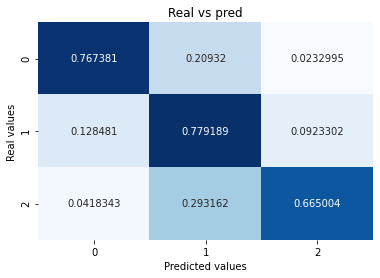

In [179]:
from sklearn.metrics import confusion_matrix

def display_cm(y_test, y_pred):    
    sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                annot = True, cmap = 'Blues', fmt='g', cbar=False)
    plt.title('Real vs pred')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');
    
    plt.show()
    
display_cm(y_test, y_pred_1)

#### 1.2. RNN - LSTM layers

In [200]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# Definimos parámetros para el modelo
DROPOUT_VAL = 0.5
BATCH_SIZE = 16
#DENSE_DIM = 3
EPOCHS = 20

# Creamos capas

layers = [
    keras.layers.Embedding(dim, 20, input_length = INPUT_LENGTH),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(15,dropout = DROPOUT_VAL),
    keras.layers.Dense(3, activation = 'softmax')   
]

model2 = keras.models.Sequential(layers)

# Compilamos

model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Añadimos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)

# Añadimos checkpoint
metric = 'val_accuracy'

checkpoint_2 = keras.callbacks.ModelCheckpoint("best_model2.hdf5",
                                    monitor = metric,
                                    verbose=1,
                                    save_best_only=True,
                                    mode='auto',
                                    save_weights_only=False)

In [201]:
# Entrenamos

history_2 = model2.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       #validation_split = 0.1,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks=[checkpoint_2, callback])

Epoch 1/20
6258/6261 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.7026
Epoch 00001: val_accuracy improved from -inf to 0.74352, saving model to best_model2.hdf5
6261/6261 [==============================] - 59s 9ms/step - loss: 0.6656 - accuracy: 0.7026 - val_loss: 0.5933 - val_accuracy: 0.7435
Epoch 2/20
6260/6261 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.7528
Epoch 00002: val_accuracy improved from 0.74352 to 0.74748, saving model to best_model2.hdf5
6261/6261 [==============================] - 59s 10ms/step - loss: 0.5795 - accuracy: 0.7528 - val_loss: 0.5876 - val_accuracy: 0.7475
Epoch 3/20
6261/6261 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.7647
Epoch 00003: val_accuracy improved from 0.74748 to 0.75552, saving model to best_model2.hdf5
6261/6261 [==============================] - 58s 9ms/step - loss: 0.5573 - accuracy: 0.7647 - val_loss: 0.5669 - val_accuracy: 0.7555
Epoch 4/20
6256/6261 [=====

In [202]:
# Evaluamos
accuracy_dl_lstm = model2.evaluate(X_test, y_test)
accuracy_dl_lstm

553/553 [==============================] - 1s 3ms/step - loss: 0.5922 - accuracy: 0.7487


[0.5922040939331055, 0.7487272024154663]

In [203]:
# Sacamos classification report
y_pred_2 = model2.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_2, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5322
           1       0.68      0.66      0.67      6141
           2       0.78      0.80      0.79      6215

    accuracy                           0.75     17678
   macro avg       0.75      0.75      0.75     17678
weighted avg       0.75      0.75      0.75     17678



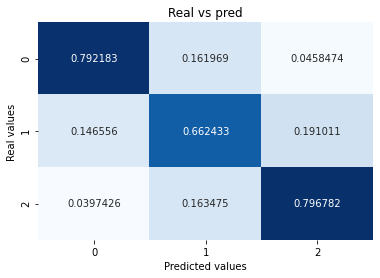

In [204]:
display_cm(y_test, y_pred_2)

#### 1.3. RNN - Bidirectional layers

In [159]:
DROPOUT_VAL = 0.6

layers = [
    keras.layers.Embedding(dim, 40, input_length = INPUT_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(3, activation = 'softmax')
]

model3 = keras.models.Sequential(layers)

# Compilamos modelo
model3.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_3 = keras.callbacks.ModelCheckpoint('best_model3.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)


In [160]:
# Entrenamos
history_3 = model3.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_3])

Epoch 1/20
6259/6261 [============================>.] - ETA: 0s - loss: 0.6268 - accuracy: 0.7241
Epoch 00001: val_accuracy improved from -inf to 0.75156, saving model to best_model3.hdf5
6261/6261 [==============================] - 95s 15ms/step - loss: 0.6268 - accuracy: 0.7241 - val_loss: 0.5719 - val_accuracy: 0.7516
Epoch 2/20
6258/6261 [============================>.] - ETA: 0s - loss: 0.5489 - accuracy: 0.7661
Epoch 00002: val_accuracy did not improve from 0.75156
6261/6261 [==============================] - 97s 16ms/step - loss: 0.5489 - accuracy: 0.7661 - val_loss: 0.5742 - val_accuracy: 0.7515
Epoch 3/20
6261/6261 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.7804 E
Epoch 00003: val_accuracy improved from 0.75156 to 0.75625, saving model to best_model3.hdf5
6261/6261 [==============================] - 103s 16ms/step - loss: 0.5215 - accuracy: 0.7804 - val_loss: 0.5784 - val_accuracy: 0.7563
Epoch 4/20
6260/6261 [============================>.] - ETA:

In [161]:
# Evaluamos
accuracy_dl_bi = model3.evaluate(X_test, y_test)
accuracy_dl_bi

553/553 [==============================] - 1s 3ms/step - loss: 0.5996 - accuracy: 0.7512


[0.5995893478393555, 0.7512161731719971]

In [164]:
# Sacamos classification report
y_pred_3 = model3.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_3, axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      5322
           1       0.65      0.73      0.69      6141
           2       0.81      0.76      0.79      6215

    accuracy                           0.75     17678
   macro avg       0.76      0.75      0.75     17678
weighted avg       0.76      0.75      0.75     17678



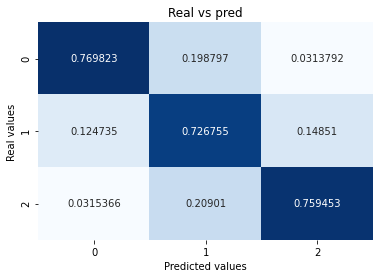

In [167]:
display_cm(y_test, y_pred_3)

#### 1.4. Conv1 layers

In [168]:
# Creamos capas

layers = [
    keras.layers.Embedding(dim, 40, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(20,
                        3,
                        activation = 'relu',
                        kernel_regularizer = regularizers.l1_l2(l1 = 2e-3, l2 = 2e-3),
                        bias_regularizer = regularizers.l2(2e-3)),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(3, activation = 'softmax')
]

model4 = keras.models.Sequential(layers)

# Compilamos
model4.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_4 = keras.callbacks.ModelCheckpoint('best_model4.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [169]:
# Entrenamos
history_4 = model4.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_4])

Epoch 1/20
6261/6261 [==============================] - ETA: 0s - loss: 1.1087 - accuracy: 0.3489
Epoch 00001: val_accuracy improved from -inf to 0.34738, saving model to best_model4.hdf5
6261/6261 [==============================] - 116s 19ms/step - loss: 1.1087 - accuracy: 0.3489 - val_loss: 1.0999 - val_accuracy: 0.3474
Epoch 2/20
6261/6261 [==============================] - ETA: 0s - loss: 1.1008 - accuracy: 0.3456
Epoch 00002: val_accuracy improved from 0.34738 to 0.35157, saving model to best_model4.hdf5
6261/6261 [==============================] - 105s 17ms/step - loss: 1.1008 - accuracy: 0.3456 - val_loss: 1.0999 - val_accuracy: 0.3516
Epoch 3/20
6259/6261 [============================>.] - ETA: 0s - loss: 1.1007 - accuracy: 0.3473
Epoch 00003: val_accuracy did not improve from 0.35157
6261/6261 [==============================] - 107s 17ms/step - loss: 1.1007 - accuracy: 0.3473 - val_loss: 1.0999 - val_accuracy: 0.3516
Epoch 4/20
6259/6261 [============================>.] - ETA:

In [170]:
# Evaluamos
accuracy_dl_conv1d = model4.evaluate(X_test, y_test)
accuracy_dl_conv1d

553/553 [==============================] - 1s 2ms/step - loss: 1.1005 - accuracy: 0.3474


[1.1005362272262573, 0.34738093614578247]

In [171]:
# Sacamos classification report
y_pred_4 = model4.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_4, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5322
           1       0.35      1.00      0.52      6141
           2       0.00      0.00      0.00      6215

    accuracy                           0.35     17678
   macro avg       0.12      0.33      0.17     17678
weighted avg       0.12      0.35      0.18     17678



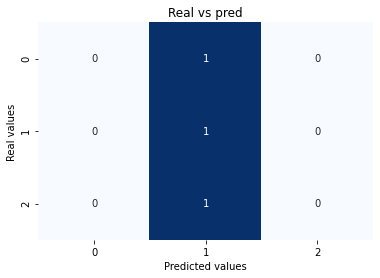

In [172]:
display_cm(y_test, y_pred_4)

### 2. CountVectorizer models

In [206]:
# Creamos X,y

X = df['content']
y = df.replace({'sentiment': {'N': -1, 'NEU': 0, 'P': 1}})['sentiment']

# Creamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [207]:
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
baseline_vectorizer = CountVectorizer(binary = True, ngram_range=(1, 2))
baseline_vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_baseline = baseline_vectorizer.transform(X_train)
X_test_baseline = baseline_vectorizer.transform(X_test)

#### 2.1. Random Forest

In [231]:
# Imprimimos tamaño
print('X_train_baseline:', X_train_baseline.shape)
print('X_test_baseline:', X_test_baseline.shape)

X_train_baseline: (100172, 558082)
X_test_baseline: (17678, 558082)


In [232]:
# Creamos objeto y entrenamos

random_forest_cv = RandomForestClassifier(n_estimators = 100,
                                          n_jobs = -1)
random_forest_cv.fit(X_train_baseline, y_train)



RandomForestClassifier(n_jobs=-1)

In [233]:
# Evaluamos
random_forest_cv.score(X_test_baseline, y_test)

0.7255345627333408

In [234]:
# Predecimos
y_pred_rf_cv = random_forest_cv.predict(X_test_baseline)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf_cv))

              precision    recall  f1-score   support

          -1       0.83      0.66      0.73      5322
           0       0.60      0.83      0.70      6141
           1       0.85      0.68      0.76      6215

    accuracy                           0.73     17678
   macro avg       0.76      0.72      0.73     17678
weighted avg       0.76      0.73      0.73     17678



In [235]:
# Sacamos el accuracy
accuracy_rf_cv = accuracy_score(y_test, y_pred_rf_cv)
accuracy_rf_cv

0.7254779952483312

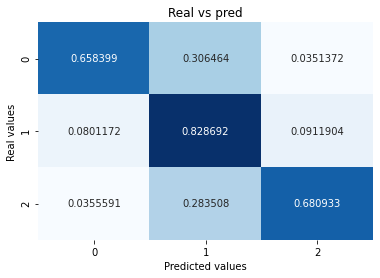

In [236]:
#display_cm(y_test, y_pred_rf_cv)
from sklearn.metrics import confusion_matrix

y_pred_rf_cv = random_forest_cv.predict(X_test_baseline)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_cv, normalize = 'true'),
            annot=True, fmt='g', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

#### 2.2. Logistic Regression

In [184]:
from sklearn.linear_model import LogisticRegression
# Creamos modelo
lr_cv_params = dict(C = [0.5, 1, 1.15, 1.5])
lr_cv_grid = GridSearchCV(LogisticRegression(),
                     lr_cv_params,
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'accuracy').fit(X_train_baseline,
                                               y_train)
print('Best score:', lr_cv_grid.best_score_)
print('Best params:', lr_cv_grid.best_params_)

Best score: 0.7680588754046994
Best params: {'C': 0.5}


In [187]:
# Predecimos
from sklearn.metrics import accuracy_score

y_pred_log_reg_cv = lr_cv_grid.predict(X_test_baseline)
accuracy_log_reg_cv = accuracy_score(y_test, y_pred_log_reg_cv)
accuracy_log_reg_cv

0.7646792623599955

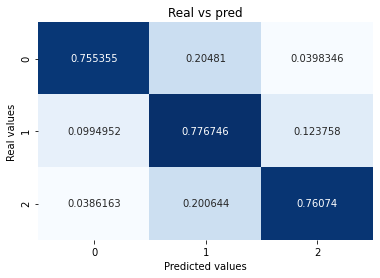

In [188]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv, normalize = 'true'),
            annot=True, fmt='g', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

#### 2.3. Linear SVC

In [189]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_lin_svc = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', LinearSVC())
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1])

lin_svc_cv = GridSearchCV(pipe_lin_svc,
                          pipe_lin_svc_params,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')
lin_svc_cv.fit(X_train_baseline, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', LinearSVC())]),
             n_jobs=-1, param_grid={'svc__C': [0.01, 0.1, 0.25, 0.5, 1]},
             scoring='accuracy')

In [190]:
# Best params
lin_svc_cv.best_params_

{'svc__C': 0.01}

In [193]:
# Predecimos

y_pred_lin_svc_cv = lin_svc_cv.predict(X_test_baseline)
accuracy_lin_svc_cv = accuracy_score(y_test, y_pred_lin_svc_cv)
accuracy_lin_svc_cv

0.6733793415544745

In [192]:
# Sacamos matriz de correlación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lin_svc_cv))

              precision    recall  f1-score   support

          -1       0.82      0.62      0.70      5322
           0       0.56      0.78      0.65      6141
           1       0.76      0.62      0.68      6215

    accuracy                           0.67     17678
   macro avg       0.71      0.67      0.68     17678
weighted avg       0.71      0.67      0.68     17678



### 3. TF-IDF Models

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos X,y

X = df_lem['content']
y = df_lem.replace({'sentiment': {'N': -1, 'NEU': 0, 'P': 1}})['sentiment']

# Creamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

# Vectorizamos
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#### 3.1. Random Forest

In [238]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Creamos objeto y entrenamos
rand_forest_tfidf = RandomForestClassifier(n_estimators = 100,
                                           n_jobs = -1)
rand_forest_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1)

In [239]:
# Evaluamos
accuracy_rand_forest_tfidf = rand_forest_tfidf.score(X_test_tfidf, y_test)
accuracy_rand_forest_tfidf

0.7029702970297029

In [240]:
# Predecimos
y_pred_rf_tfidf = rand_forest_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_rf_tfidf))

              precision    recall  f1-score   support

          -1       0.75      0.69      0.72      5323
           0       0.62      0.71      0.66      6195
           1       0.76      0.71      0.73      6157

    accuracy                           0.70     17675
   macro avg       0.71      0.70      0.71     17675
weighted avg       0.71      0.70      0.70     17675



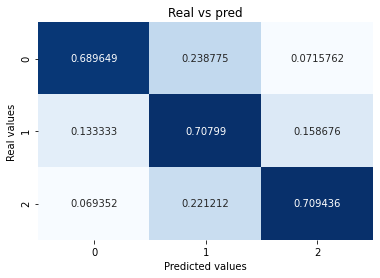

In [241]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tfidf, normalize = 'true'),
            annot=True, fmt='g', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

#### 3.2. Logistic Regression

In [243]:
# Entrenamos reg. log
from sklearn.linear_model import LogisticRegression

lr_tfidf_params = dict(
    C = [0.5, 1, 1.5, 2]
)
lr_tfidf = GridSearchCV(LogisticRegression(),
                        lr_tfidf_params,
                        cv = 5,
                        scoring = 'accuracy',
                        n_jobs = -1).fit(X_train_tfidf, y_train)

print('Best score:', lr_tfidf.best_score_)
print('Best params:', lr_tfidf.best_params_)

Best score: 0.7072695927542341
Best params: {'C': 1}


In [244]:
# Predecimos
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
accuracy_lr_tfidf

0.711966053748232

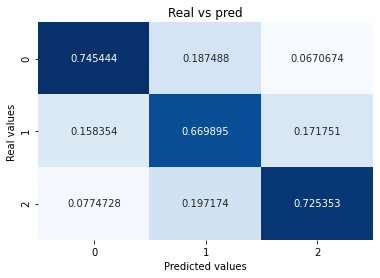

In [245]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tfidf, normalize = 'true'),
            annot=True, fmt='g', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

#### 3.3. Linear SVC

In [247]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


lin_svc_tfidf_params = dict(C = [0.01, 0.1, 0.25, 0.5, 1])

lin_svc_tfidf = GridSearchCV(LinearSVC(),
                          lin_svc_tfidf_params,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')
lin_svc_tfidf.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.25, 0.5, 1]}, scoring='accuracy')

In [248]:
# Predecimos

y_pred_lin_svc_tfidf = lin_svc_tfidf.predict(X_test_tfidf)
accuracy_lin_svc_tfidf = accuracy_score(y_test, y_pred_lin_svc_tfidf)
accuracy_lin_svc_tfidf

0.7146817538896747

In [249]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_tfidf))

              precision    recall  f1-score   support

          -1       0.73      0.75      0.74      5323
           0       0.66      0.67      0.66      6195
           1       0.76      0.73      0.75      6157

    accuracy                           0.71     17675
   macro avg       0.72      0.72      0.72     17675
weighted avg       0.72      0.71      0.71     17675



## 4. Escogiendo el mejor modelo

In [250]:
# Tabla con accuracy de todos ellos
accuracy_list = [accuracy_dl_gru[1],
                 accuracy_dl_lstm[1],
                 accuracy_dl_bi[1],
                 accuracy_dl_conv1d[1],
                 accuracy_rf_cv,
                 accuracy_log_reg_cv,
                 accuracy_lin_svc_cv,
                 accuracy_rand_forest_tfidf,
                 accuracy_lr_tfidf,
                 accuracy_lin_svc_tfidf]

columns = ['NN GRU layers', 'NN LSTM layers', 'RNN Bidirectional', 'RNN Conv1d', 'RandForest CountVectorizer',
           'LinReg CountVectorizer', 'Linear SVC CountVectorizer', 'RandForest TFIDF', 'LinReg TFIDF',
           'Linear SVC TFIDF']
df_scores = pd.DataFrame(np.c_[columns, round(pd.Series(accuracy_list), 4)], columns = ['Model', 'Val score']).set_index('Model')
df_scores

,Val score
Model,
NN GRU layers,0.7355
NN LSTM layers,0.7487
RNN Bidirectional,0.7512
RNN Conv1d,0.3474
RandForest CountVectorizer,0.7255
LinReg CountVectorizer,0.7647
Linear SVC CountVectorizer,0.6734
RandForest TFIDF,0.703
LinReg TFIDF,0.712


Elegimos el modelo de RNN Bidireccional y la Regresión logística con CountVectorizer.

In [318]:
feature_to_coef

{'10': 0.06871822918117072,
 '10 asir': 0.13603192901528707,
 '10 certificar': -0.0007135600757801335,
 '10 edición': -0.011658592225935172,
 '10 evitar': -0.0553107205683092,
 '10 intentar': -0.0007047701437925178,
 '10 legislatura': -0.00887778835154839,
 '10 mejor': -0.01224875032134761,
 '10 parlamentario': -0.03440287862417718,
 '10 pensamiento': -0.012144229863225131,
 '10 premiar': 0.06874759034,
 '1000': 0.0328945391556391,
 '1000 atacar': 0.0328945391556391,
 '11': 0.13688077226197404,
 '11 yo': 0.13688077226197404,
 '12': -0.0010932379379696572,
 '12 feliz': -0.0010932379379696572,
 '30': -0.013342612527782505,
 '30 director': -0.013342612527782505,
 '_ainely': -0.039268930266760683,
 '_ainely no': -0.039268930266760683,
 '_alexuanteik': 0.0028142233918196234,
 '_alexuanteik menc': 0.0028142233918196234,
 '_ambarmartinez': 0.001015231547705421,
 '_ambarmartinez margarita': 0.001015231547705421,
 '_danielmartin': -0.017799146413896263,
 '_danielmartin día': -0.0177991464138962

In [321]:
# Montamos un diccionario con palabra -> coeficiente
feature_to_coef = {
    word: coef for word, coef in zip(
        baseline_vectorizer.get_feature_names(), lr_cv_grid.best_estimator_.coef_[0]
    )
}

# Coge las features que más aportan a los positivos y negativos

for best_positive in sorted(feature_to_coef.items(),
                            key=lambda x: x[1],
                            reverse=True)[:10]:
    print(best_positive)
    
print('################################')

for best_negative in sorted(feature_to_coef.items(),
                            key=lambda x: x[1])[:10]:
    print(best_negative)

('emoji_neg', 4.497252722081106)
('déficit', 2.0392665121495828)
('triste', 1.8634885448424165)
('peor', 1.8458940649578657)
('mentira', 1.6447883530714629)
('eta', 1.5289000926760747)
('denunciar', 1.517746969863973)
('malo', 1.5087614996951775)
('muerto', 1.4930003386102562)
('atacar', 1.4642271219557927)
################################
('emoji_pos', -2.444537239235689)
('no perder', -1.4024234375462785)
('enhorabuena', -1.1355495617281453)
('homenaje', -1.125102113093568)
('no dormir', -1.0921525107389254)
('página', -1.0709261027076389)
('feliz', -1.0292421792503832)
('beso', -1.0230462745946853)
('encantar', -0.9805996014639831)
('gracia', -0.9776196398407389)


In [322]:
# Usamos eli5 para sacar las features más predictoras. MÉTODO 2
import eli5
from eli5 import explain_weights, explain_prediction


eli5.show_weights(lr_cv_grid.best_estimator_,
                  vec = baseline_vectorizer,
                  target_names = df['sentiment'],
                  horizontal_layout=False)

Weight?,Feature
+4.497,emoji_neg
+2.039,déficit
+1.863,triste
+1.846,peor
+1.645,mentira
+1.529,eta
+1.518,denunciar
+1.509,malo
+1.493,muerto
+1.464,atacar


## 5. Predecimos con el modelo escogido

### 5.1. Logistic Regression CountVectorizer

In [290]:
def pred_tweet(text):
    text = transform_tweets(text)
    
    sentiment = ['Negativo', 'Neutro', 'Positivo']
    X_pred = baseline_vectorizer.transform([text])
    
    print(lr_cv_grid.predict_proba(X_pred))
    print('Tweet sentiment:', sentiment[np.argmax(lr_cv_grid.predict_proba(X_pred))])

In [291]:
pred_tweet('Yo hago caso a expertos de verdad y no voy a ser una puta rata de laboratorio. #YoNoMeVacuno')

[[0.60163742 0.27223909 0.12612348]]
Tweet sentiment: Negativo


In [307]:
pred_tweet('Losantos contrata a la farmacéutica Pfizer \
para que descubra una vacuna contra el comunismo')

[[0.092018   0.79815555 0.10982645]]
Tweet sentiment: Neutro


In [293]:
pred_tweet('Están yendo descaradamente a por Joao. Y no es que no saque amarilla, es que no pita ni falta.')

[[0.79217683 0.19842511 0.00939806]]
Tweet sentiment: Negativo


In [296]:
pred_tweet("""Que el 90% de los mensajes que se están dando de cara \
a las navidades están hechos pensando en familias nucleares estándar es algo que me fascina.
El no te juntes con nadie puede ser un poquito duro si vives solo, por ejemplo, y no es precisamente el caso de poca gente.""")

[[0.98917796 0.00448227 0.00633978]]
Tweet sentiment: Negativo


In [308]:
pred_tweet('¡Enhorabuena! Trabajazo de @susanasolisp como \
negociadora del @Europarl_ES de los fondos estructurales. \
Explicación en el hilo.')

[[0.11647312 0.43517309 0.44835379]]
Tweet sentiment: Positivo


In [267]:
text = """
Me duele mucho la cabeza y no tengo comida. Help
"""

text = transform_tweets(text)

sentiment = ['Negativo', 'Neutro', 'Positivo']
X_pred = baseline_vectorizer.transform([text])

print(lr_cv_grid.predict_proba(X_pred))
print('Tweet sentiment:', sentiment[np.argmax(lr_cv_grid.predict(X_pred))])

[[0.74738702 0.23372688 0.01888611]]
Tweet sentiment: Negativo


### 5.2. RNN Bidireccional

In [64]:
# Cargamos modelo 
path_model = 'best_model3.hdf5'

best_model = load_model(path_model)

best_model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 25, 40)            3000640   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 123       
Total params: 3,010,523
Trainable params: 3,010,523
Non-trainable params: 0
_________________________________________________________________


In [311]:
text = """
Me duele la cabeza y no tengo comida. Help :(
"""
X_pred = transform_tweets(text)
X_pred

'doler cabeza no comer help {emoji_neg}'

In [312]:
sentiment = ['Negativo', 'Neutro', 'Positivo']
sequence = tokenizer.texts_to_sequences([X_pred])
X_pred = keras.preprocessing.sequence.pad_sequences(sequence, maxlen=INPUT_LENGTH)
print(best_model.predict(X_pred))
print('Tweet sentiment:', sentiment[np.argmax(best_model.predict(X_pred))])

[[0.51126826 0.14604531 0.34268644]]
Tweet sentiment: Negativo
